In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt

from numpy import *
from scipy import *
from BlackScholes import *
from torch import optim
from gpytorch.kernels import RBFKernel, MultitaskKernel
from gpytorch.means import ConstantMean, MultitaskMean
from gpytorch.likelihoods import MultitaskGaussianLikelihood
from gpytorch.random_variables import MultitaskGaussianRandomVariable


%matplotlib inline
%load_ext autoreload
%autoreload 2

### set BS model parameters

In [3]:
r = 0.0002  # risk-free rate
S= 100      # Underlying spot
KC = 130    # Call strike
KP = 70     # Put strike
sigma = 0.4 # implied volatility
T = 2.0     # Time to maturity

In [ ]:
# define the call and put prices using the BS model
call = lambda x: bsformula(1, lb+(ub-lb)*x, KC, r, T, sigma, 0)[0]
put = lambda x: bsformula(-1, lb+(ub-lb)*x, KP, r, T, sigma, 0)[0]

## define multi-GP class

In [4]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = MultitaskMean(ConstantMean(), n_tasks=2)
        self.data_covar_module = RBFKernel()
        self.covar_module = MultitaskKernel(self.data_covar_module, n_tasks=2, rank=1)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultitaskGaussianRandomVariable(mean_x, covar_x)

In [5]:
lb = 0.001           # lower bound on domain
ub = 300             # upper bound on domain
training_number = 30 # Number of training samples
testing_number = 100 # Number of testing samples

train_x = torch.linspace(0, 1.0, training_number)

train_y1 = torch.FloatTensor(call(np.array(train_x)))
train_y2 = torch.FloatTensor(put(np.array(train_x)))

#Create a train_y which interleaves the two
train_y = torch.stack([train_y1, train_y2], -1)

In [6]:
test_x = torch.linspace(0, 1.0, testing_number)
test_y1 = torch.FloatTensor(call(np.array(test_x)))
test_y2 = torch.FloatTensor(put(np.array(test_x)))
test_y = torch.stack([test_y1, test_y2], -1)

In [7]:
# Gaussian likelihood is used for regression to give predictive mean+variance
# and learn noise
likelihood = MultitaskGaussianLikelihood(n_tasks=2)
gp = MultitaskGPModel(train_x, train_y, likelihood)
gp.train()
likelihood.train()


# Use the adam optimizer
optimizer = torch.optim.Adam([
            {'params': gp.parameters()},  # Includes GaussianLikelihood parameters
            ], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp)

n_iter = 300
for i in range(n_iter):
    # Zero prev backpropped gradients
    optimizer.zero_grad()
    # Make predictions from training data
    # Again, note feeding duplicated x_data and indices indicating which task
    output = gp(train_x)
    # TODO: Fix this view call!!
    loss = -mll(output, train_y)
    loss.backward()
    if (i % 10==0):
      print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()


Iter 1/300 - Loss: 2135.037
Iter 11/300 - Loss: 420.291
Iter 21/300 - Loss: 212.335
Iter 31/300 - Loss: 155.522
Iter 41/300 - Loss: 128.766
Iter 51/300 - Loss: 113.396
Iter 61/300 - Loss: 105.197
Iter 71/300 - Loss: 98.533
Iter 81/300 - Loss: 91.845
Iter 91/300 - Loss: 86.200
Iter 101/300 - Loss: 80.839
Iter 111/300 - Loss: 78.189
Iter 121/300 - Loss: 73.571
Iter 131/300 - Loss: 70.681
Iter 141/300 - Loss: 71.006
Iter 151/300 - Loss: 67.436
Iter 161/300 - Loss: 67.679
Iter 171/300 - Loss: 64.899
Iter 181/300 - Loss: 60.218
Iter 191/300 - Loss: 61.577
Iter 201/300 - Loss: 58.865
Iter 211/300 - Loss: 55.827
Iter 221/300 - Loss: 53.709
Iter 231/300 - Loss: 51.697
Iter 241/300 - Loss: 50.875
Iter 251/300 - Loss: 49.751
Iter 261/300 - Loss: 48.242
Iter 271/300 - Loss: 48.482
Iter 281/300 - Loss: 45.819
Iter 291/300 - Loss: 41.871


In [8]:
# Make predictions
gp.eval()
likelihood.eval()
with torch.no_grad():
    y_hat= likelihood(gp(test_x))
 
lower, upper = y_hat.confidence_region()

Text(0,0.5,'V')

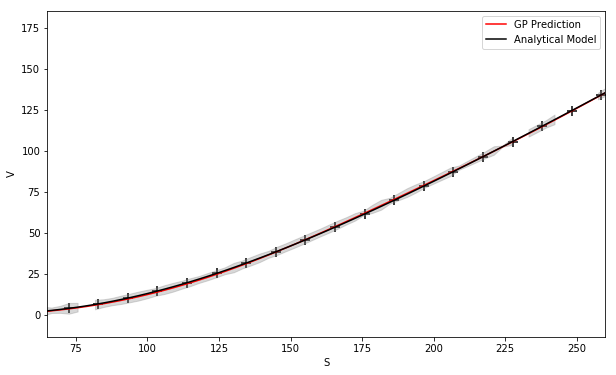

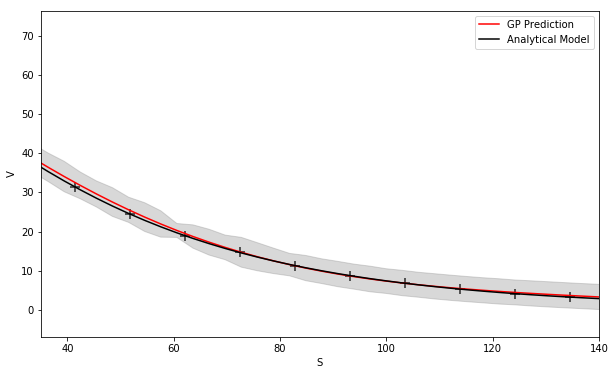

In [9]:
# predictionn plot with var band 
plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean()[:,0]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,0]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,0], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,0].detach().numpy(), upper[:,0].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KC/2.0,2*KC])
plt.xlabel('S')
plt.ylabel('V')


plt.figure(figsize = (10, 6), facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(y_hat.mean()[:,1]), color = 'red', label = 'GP Prediction')
plt.plot(lb+(ub-lb)*np.array(test_x.flatten()), np.array(test_y[:,1]), color = 'black', label = 'Analytical Model')
plt.scatter(lb+(ub-lb)*train_x, train_y[:,1], color = 'black', marker = '+', s = 100) 
plt.fill_between(lb+(ub-lb)*np.array(test_x.flatten()), lower[:,1].detach().numpy(), upper[:,1].detach().numpy(), color = 'grey', alpha=0.3)
plt.legend(loc = 'best', prop={'size':10})
plt.xlim([KP/2.0,2*KP])
plt.xlabel('S')
plt.ylabel('V')